In [1]:
import os
import pandas as pd
import upsetplot
from functools import reduce
from itertools import combinations
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight')
    pdf.close()
    return

In [3]:
combo_dir = "/data5/deepro/ukbiobank/papers/bmi_project/3_run_rarecomb"
group_names = ["white_british", "white_british_male", "white_british_female", "pre_menopause", "post_menopause"]

In [4]:
def get_sorted_combos(ser, ncombo):
    return ";".join(sorted(ser.loc[[f"Item_{i}_symbol" for i in range(1, ncombo + 1)]]))

def get_combo_set(combo_dir, group):
    combo2_file = os.path.join(combo_dir, group, "data", "parsed_tables", "combo_2.csv")
    combo3_file = os.path.join(combo_dir, group, "data", "parsed_tables", "combo_3.csv")
    try:
        combo2_df = pd.read_csv(combo2_file)
        combo2_df["combo_name"] = combo2_df.apply(get_sorted_combos, args=(2, ), axis=1)
        combo2_set = set(combo2_df.combo_name.to_list())
    except FileNotFoundError:
        combo2_set = set()
    try:
        combo3_df = pd.read_csv(combo3_file)
        combo3_df["combo_name"] = combo3_df.apply(get_sorted_combos, args=(3, ), axis=1)
        combo3_set = set(combo3_df.combo_name.to_list())
    except FileNotFoundError:
        combo3_set =set()
    combo_set = combo2_set.union(combo3_set)
    return combo_set

In [5]:
def set_add(a, b):
    return a.intersection(b)

def set_subtract(a,b):
    return a.difference(b)

def get_intersects(include_sets, exclude_sets):
    intersect_sets = reduce(set_add, include_sets)
    if len(exclude_sets)>0:
        exclude_sets = [intersect_sets] + exclude_sets
        intersect_sets = reduce(set_subtract, exclude_sets)
    return intersect_sets

def get_upset_df(combo_dir, groups):
    # get the set of gene combinations for each group
    combo_dict = {g: get_combo_set(combo_dir, g) for g in groups}
    combo_boolean_dict = {g:[] for g in groups}
    counts = []
    unique_intersect_sets = dict()
    for i in range(1, len(groups) + 1):
        # get combinations of length i
        all_combos = list(combinations(groups, i))
        for combos in all_combos:
            # get counts of elements that are unique to the combinations
            include_combos = combos
            exclude_combos = tuple(g for g in groups if g not in include_combos)
            include_sets = [combo_dict[c] for c in include_combos]
            exclude_sets = [combo_dict[c] for c in exclude_combos]
            unique_intersects = get_intersects(include_sets, exclude_sets)
            counts.append(len(unique_intersects))
            unique_intersect_sets[(include_combos, exclude_combos)] = unique_intersects
            for c in include_combos:
                combo_boolean_dict[c].append(True)
            for c in exclude_combos:
                combo_boolean_dict[c].append(False)
    combo_boolean_dict["counts"] = counts
    df = pd.DataFrame(combo_boolean_dict)
    return df.set_index(groups), unique_intersect_sets

In [6]:
upset_df, unique_intersects = get_upset_df(combo_dir, group_names)

In [7]:
parsed_upset_df = upset_df.loc[upset_df.counts>0]

(0.0, 1.0, 0.0, 1.0)

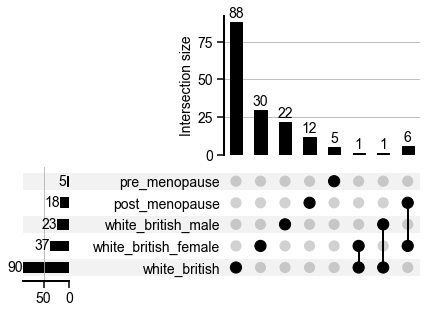

In [14]:
fig,ax = plt.subplots(1,1)
upsetplot.plot(parsed_upset_df.counts, show_counts=True, fig=fig)
ax.axis("off")

In [15]:
save_file = "/data5/deepro/ukbiobank/papers/bmi_project/4_characterization/shared/data/overlap/shared_combos.pdf"
save_pdf(save_file, fig)

In [9]:
wbf_postm_intersects = unique_intersects[('white_british_female', 'post_menopause',), ('white_british', 'white_british_male', 'pre_menopause',)]

In [10]:
save_file = "/data5/deepro/ukbiobank/papers/bmi_project/4_characterization/shared/data/overlap/wbfemale_postm_overlap.txt"

with open(save_file, "w") as f:
    for combo in wbf_postm_intersects:
        f.write(f"{combo}\n")